# Task c

Frederik Rogge, Mouhammad Abu Rasheed and Homa Priya Tarigopula

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as LR
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
import matplotlib.pyplot as plt
from sklearn.utils import resample
import os
%matplotlib inline

from utils import *
from resampling import *
np.random.seed(0)


In [2]:
# Create data
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x, y)

# Compute z
z = FrankeFunction(x, y)

# Create features as pairs of (x, y)
features = np.stack([x.ravel(), y.ravel()], axis=1)


# Get labels
labels = z.ravel()
labels = labels.reshape((-1,1))


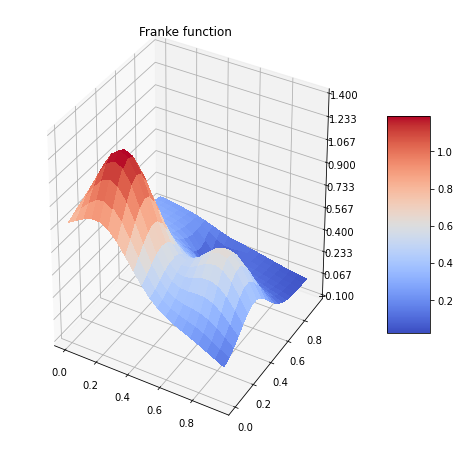

In [3]:
def plot_function(x, y, z, title=None):
    # Plot function
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface.
    surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

    ax.set_zlim(-0.10, 1.40)
    ax.zaxis.set_major_locator(LinearLocator(10))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    if title is not None:
        plt.title(title)
    
    plt.show()
    
plot_function(x, y, z, 'Franke function')

## Part c) : Cross validation as resampling techniques

In [4]:
k_values  = [5, 6, 7,8, 9, 10]  # Number of folds

degree_values = np.arange(1, 6)  # Specify degree of polynomial to be fitted

# define the model we want to use 
solver = LinearRegression

#define the input argumets for the solver 
solver_args ={ 'fit_intercept': False }

In [5]:
def gen_plot_kfold(n_datapoints, polynomial, estimated_mse, title , y_label, legend_label, fig_name):
    fig, ax = plt.subplots()
    for n,k in enumerate(n_datapoints):
        ax.plot(polynomial, np.log10(estimated_mse[:, n]), label= legend_label +', k = '+ str(k)  )
        ax.set_xlabel('Polynomial degree')
        ax.set_ylabel( y_label)
        ax.set_xticks(polynomial)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        save_fig(fig , name =fig_name + legend_label )
    ax.set_title(title)
    plt.show()
    

### K-fold cross validation

In [6]:
def plot_kfold_implementation(features, labels , k_values, degree_values, fig_name, solver = LinearRegression,
                              scaling= True , add_noise= True, mean = 0, std = 1, **solver_args):
    
    Maxpolydegree = np.max(degree_values)
    polynomial = np.zeros(Maxpolydegree)
    estimated_train_mse = np.zeros((Maxpolydegree,  len(k_values)))
    estimated_test_mse = np.zeros((Maxpolydegree,len(k_values)))

    if add_noise :
        np.random.seed(1)
        labels_n = labels +  np.random.normal(mean, std, labels.shape )
    else :
        labels_n = labels
    

    for polydegree in range(1, Maxpolydegree+1):
        polynomial[polydegree-1] = polydegree
        
    for degree in degree_values:
        # fit polynomials on test and train
        poly = PolynomialFeatures(degree, include_bias=not scaling)
        features_poly = poly.fit_transform(features)

        if scaling:
            # Scale data
            scaler = StandardScaler(with_std=True)
            feature_scale = scaler.fit_transform(features_poly)
            
        for n,k in enumerate(k_values):
            
            kf = KFoldCV()      #Implementation from resampling.py
            
            test_MSE, train_MSE = kf.cv(feature_scale, labels_n , degree, k, scaling = scaling,  solver = solver, **solver_args )
            
            #print(test_MSE)

            estimated_train_mse[degree-1, n] = np.mean(train_MSE)
            estimated_test_mse[degree-1, n] = np.mean(test_MSE)

    print('MSE on test-set : \n',estimated_test_mse)

    #gen_plot_kfold(k_values, polynomial, estimated_train_mse,
    #         title = 'k-fold cv implementation for different order polynomials' ,
    #        y_label = 'MSE',
    #        legend_label = 'Train Error', fig_name = fig_name)

    gen_plot_kfold(k_values, polynomial, estimated_test_mse,
             title = 'k-fold cv implementation for different order polynomials' ,
             y_label = 'MSE',
            legend_label = 'Test Error', fig_name = fig_name)
    
    return estimated_test_mse
    





#### With noise


MSE on test-set : 
 [[1.34587946 1.31694761 1.30845432 1.30527079 1.28751419 1.28175421]
 [1.999151   1.75592936 1.66131451 1.59693708 1.49128038 1.4510842 ]
 [3.09615249 2.74287796 2.4847664  2.32555922 1.99204871 1.80077462]
 [4.35451651 4.22956755 4.21221681 4.05844739 3.49598341 2.8580672 ]
 [5.29351037 6.09953991 6.21783636 6.88390426 6.37686565 4.6322178 ]]


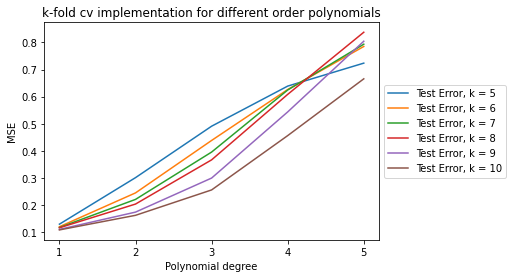

In [7]:
est_test_mse_noise = plot_kfold_implementation(features, labels ,k_values, degree_values, fig_name ='c_kfold_withnoise_', solver = solver, **solver_args) 



#### Without noise

MSE on test-set : 
 [[0.32366049 0.29909534 0.27903476 0.26844629 0.25779501 0.24957693]
 [0.82329404 0.65291565 0.52914944 0.45905498 0.39906147 0.36378993]
 [1.70027924 1.45007485 1.17341449 0.97510195 0.77297957 0.65319171]
 [2.55147163 2.58150072 2.35717075 2.15828944 1.77990376 1.48633659]
 [3.15273856 3.37135844 3.37295666 3.5215506  3.19653591 2.87090739]]


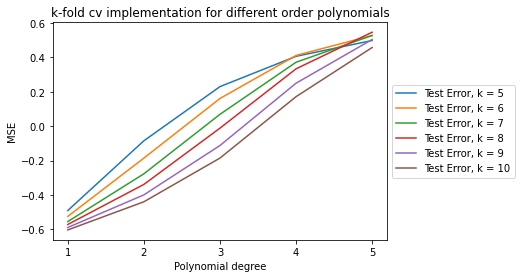

In [8]:
est_test_mse = plot_kfold_implementation(features,labels , k_values, degree_values, scaling= True, add_noise= False, fig_name ='c_kfold_without_noise_',solver = solver, **solver_args ) 


### K-fold cross validation with scikit learn 

In [9]:
def plot_Kfold_scikit(features, labels , k_values, degree_values, fig_name ,scaling= True , add_noise= True, mean = 0, std = 1, solver = LR, **solver_args ):
    Maxpolydegree = np.max(degree_values)
    estimated_mse_sklearn = np.zeros((Maxpolydegree, len(k_values)))
    polynomial = np.zeros(Maxpolydegree)

    if add_noise :
        np.random.seed(1)
        labels_n = labels + np.random.normal(mean, std, labels.shape)
    else :
        labels_n = labels
    
    for polydegree in range(1, Maxpolydegree+1):
        polynomial[polydegree-1] = int(polydegree)

    for n,k in enumerate(k_values):
        for degree in degree_values:
            
            #Input feature transformation
            poly = PolynomialFeatures(degree, include_bias= not scaling)
            feature_poly= poly.fit_transform(features)

            if scaling:
                #Scale data 
                scaler = StandardScaler(with_std=True)
                feature_scale = scaler.fit_transform(feature_poly)
                        
            Reg = solver(**solver_args)
                        
            # loop over folds in order to estimate the expectation value of the MSE
            estimated_mse_folds = np.zeros(degree)
            estimated_mse_folds = -cross_val_score(Reg , feature_scale, labels_n, scoring='neg_mean_squared_error', cv=k )
            #print(estimated_mse_folds )
            estimated_mse_sklearn[degree-1, n] = np.mean(estimated_mse_folds)
  
    print('MSE on test-set : \n',  estimated_mse_sklearn)
    gen_plot_kfold(k_values, polynomial, estimated_mse_sklearn, 
             title = 'Scikit k-fold cv for different order polynomials' ,
             y_label = 'MSE',
            legend_label = 'Test Error',  fig_name=  fig_name)
    
    return estimated_mse_sklearn

#### With noise

MSE on test-set : 
 [[1.34587946 1.31694761 1.30845432 1.30527079 1.28751419 1.28175421]
 [1.999151   1.75592936 1.66131451 1.59693708 1.49128038 1.4510842 ]
 [3.09615249 2.74287796 2.4847664  2.32555922 1.99204871 1.80077462]
 [4.35451651 4.22956755 4.21221681 4.05844739 3.49598341 2.8580672 ]
 [5.29351037 6.09953991 6.21783636 6.88390426 6.37686565 4.6322178 ]]


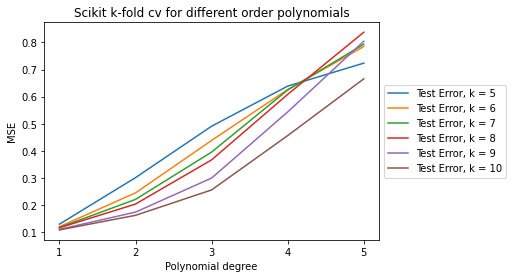

In [10]:
# define the model we want to use 
solver = LR

#define the input argumets for the solver 
solver_args ={ 'fit_intercept': False }

estimated_mse_sklearn_noise = plot_Kfold_scikit(features,labels , k_values, degree_values, fig_name ='c_scikit_kfold_withnoise_', solver = solver , **solver_args) 


#### Without noise

MSE on test-set : 
 [[0.32366049 0.29909534 0.27903476 0.26844629 0.25779501 0.24957693]
 [0.82329404 0.65291565 0.52914944 0.45905498 0.39906147 0.36378993]
 [1.70027924 1.45007485 1.17341449 0.97510195 0.77297957 0.65319171]
 [2.55147163 2.58150072 2.35717075 2.15828944 1.77990376 1.48633659]
 [3.15273856 3.37135844 3.37295666 3.5215506  3.19653591 2.87090739]]


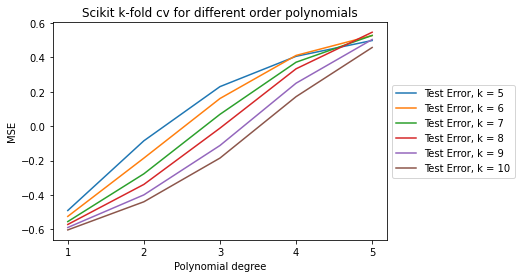

In [11]:
estimated_mse_sklearn = plot_Kfold_scikit(features,labels , k_values, degree_values, scaling= True, add_noise= False, fig_name= 'c_scikit_kfold_without_noise_',solver = solver , **solver_args) 


In [12]:
print(np.isclose(est_test_mse_noise, estimated_mse_sklearn_noise))
print(np.isclose(est_test_mse, estimated_mse_sklearn))

[[ True  True  True  True  True  True]
 [ True  True  True  True  True  True]
 [ True  True  True  True  True  True]
 [ True  True  True  True  True  True]
 [ True  True  True  True  True  True]]
[[ True  True  True  True  True  True]
 [ True  True  True  True  True  True]
 [ True  True  True  True  True  True]
 [ True  True  True  True  True  True]
 [ True  True  True  True  True  True]]
